# Amazon Food Review Data Preprocessing

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CS221/Project/'
FOLDERNAME = 'CS221/CS221Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


## Import the data

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

%matplotlib inline

In [3]:
# DATA_PATH = '../Data/Amazon/OriginalCSV/Reviews.csv'
DATA_PATH = '/content/drive/My Drive/CS221/CS221Project/Reviews.csv'
reviews = pd.read_csv(DATA_PATH)
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Split Training and Test Data

In [4]:
# pick the 'Text' column as input, and 'Summary' column as label
X = reviews['Text']
Y = reviews['Summary']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
print ('Number of samples in training data:',len(x_train))
print ('Number of samples in test data:',len(x_test))

Number of samples in training data: 454763
Number of samples in test data: 113691


In [5]:
print(x_train[0:5])
print(y_train[0:5])

print(x_train[0])

332748    Makes a terrific tasting cake.  We were surpri...
72833     Love the product but the price is to high on h...
110071    I'm grateful for my Keurig coffee maker!  The ...
82716     I really like Sylvia's seasoning so I thought ...
114920    Who knew they produced huge bottles of this fa...
Name: Text, dtype: object
332748                               review
72833     Great Product to high priced here
110071                          great taste
82716                  WHERE'S THE BEANS???
114920                                LoriP
Name: Summary, dtype: object
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [6]:
x_train_sample, y_train_sample = x_train[:10000], y_train[:10000]
x_train_list = x_train_sample.tolist()
y_train_list = y_train_sample.tolist()

max_x_length = max_y_length = 0
word_set = set()

for i in range(len(x_train_list)):
  x_train_list[i] = x_train_list[i].split()
  max_x_length = max(max_x_length, len(x_train_list[i]))
  word_set.update(x_train_list[i])
for i in range(len(y_train_list)):
  if type(y_train_list[i]) == str:
    y_train_list[i] = y_train_list[i].split()
    max_y_length = max(max_y_length, len(y_train_list[i]))
  else:
    y_train_list[i] = ['']

print(max_x_length)
print(max_y_length)
print(len(word_set))

for i in range(len(x_train_list)):
  x_train_list[i] += [''] * (max_x_length - len(x_train_list[i]))
  
for i in range(len(y_train_list)):
  y_train_list[i] += [''] * (max_y_length - len(y_train_list[i]))

X_train = tf.convert_to_tensor(x_train_list)
Y_train = tf.convert_to_tensor(y_train_list)

1853
23


# Baseline model

In [39]:
vocab_size = 1
src_txt_length = max_x_length
sum_txt_length = max_y_length

# vocab_size = len(word_set)
# src_txt_length = len(x_train_list)
# sum_txt_length = len(y_train_list)

# encoder input model
inputs = tf.keras.Input(shape=(src_txt_length, ))
encoder1 = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
encoder2 = tf.keras.layers.LSTM(128)(encoder1)
encoder3 = tf.keras.layers.RepeatVector(sum_txt_length)(encoder2)

# decoder output model
decoder1 = tf.keras.layers.LSTM(128, return_sequences=True)(encoder3)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))(decoder1)

# tie it together
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [41]:
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1853)]            0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 1853, 128)         128       
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 23, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 23, 128)           131584    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 23, 1)             129       
Total params: 263,425
Trainable params: 263,425
Non-trainable params: 0
_______________________________________________

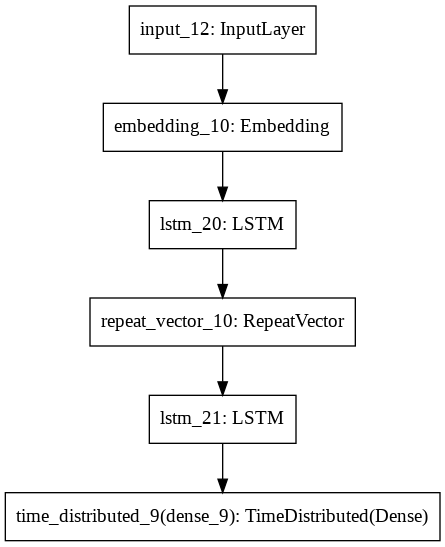

In [45]:
tf.keras.utils.plot_model(model)

In [46]:
print(X_train.shape)
print(Y_train.shape)
model.fit(X_train, Y_train, epochs=100)

(10000, 1853)
(10000, 23)
Epoch 1/100


UnimplementedError: ignored